# Action Recognition: American Sign Language (ASL) Detection
<br>

### Premise

We'd be working with opencv for collecting data from the feed of our web cam to train our neural network. We don't use the image data but the media pipe key points in vectors for training our LSTM model. Then we try and find the optimal hyperparameters for our model using keras tuner. After attaining the best possible accuracy, we test the model in realtime.

### Why media pipe + LSTM approach ?

When researching on this project, it was found that SOTA mechanisms in action recognition employ pretrained models with CNN followed a bunch of LSTM layers. When this exact approach was used, the accuracy was nowhere near being useful for the data we choose to use ie 30 sequences per class of action that in our case would be 90 sequences in total.

But, when this particular approach of mediapipe+LSTM was used for such a small amount of data, the `accuracy` was not just higher but the `training period` of the model was also faster. In addition, because the neural network `architecture` was a lot simpler, it meant that it was gonna be a whole heap faster when it comes to realtime detection. 

Also, a pro of mediapipe is that more often than not it is going to fit into `memory`, so you don't need to build a data generator to be able to build a pipeline of data. Ergo you're going to be able to train the model on the fly.

# 1. Setting up dependencies 

In [ ]:
!pip3 install -U mediapipe

In [ ]:
!pip3 install -U opencv-python

In [ ]:
!pip3 install keras-tuner

# 2. Library imports

In [1]:
import numpy as np
import os

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
from tensorflow.keras.utils import plot_model
import pydot
import graphviz

import cv2
import mediapipe as mp

import keras_tuner as kt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import TensorBoard
# Helps log onto tensorboard if we want to trace and monitor our model as it's training

2023-03-15 06:48:11.589299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-15 06:48:11.802817: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-15 06:48:11.844278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-15 06:48:11.844312: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

# Keys points using MP Holistic

In [2]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

By default when we get a feed from opencv it reads that feed in the channel format of BGR but 
when we actually go to make a detection using a mediapipe, we need it to be in the format of RGB 
so we make that conversion using opencv itself.

In [3]:
# The model here refers to the mp holistic model and the image is our frame from opencv
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable: this saves memory
    results = model.process(image)                 # Make prediction; this line is actually detecting with mp
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

`result` is the expected output from the mediapipe model, which we'll eventually render on `image` so we see our landmarks (the keypoints and structural lines).


In [4]:
# def draw_landmarks(image, results):
#     mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
#     mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
#     mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
#     mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [4]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

Here, we're setting up the camera to be accessed from opencv and then apply a secondary layer which we're actually going to make detections from, using media pipe. How the mediapipe works is, it'll initially make a detection and then from there it'll actually just track the key points.

The device number in the VideoCapture can be found by running the following command in terminal:
```ls /dev/video*```

In [7]:
# cap variable helps read the feed from our webcam 
cap = cv2.VideoCapture(2)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    # This is double checking that we're still accessing the webcam before looping through the frames
    while cap.isOpened():
        # Read feed
        ret, frame = cap.read()
    
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
    
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
    
        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): # we're gonna wait for a key to be pressed, and if this key is 'q' then we break out of the loop
            break
    cap.release() # release webcam
    cv2.destroyAllWindows() # close down our frame

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

In [8]:
results.pose_landmarks.landmark[0]

x: 0.5503873229026794
y: 0.3914092481136322
z: -0.8787252306938171
visibility: 0.9999631643295288

In [9]:
# frame contains the last image of our feed
draw_styled_landmarks(frame,results)

(-0.5, 639.5, 479.5, -0.5)

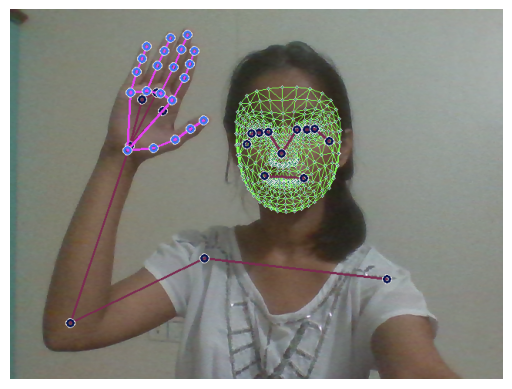

In [10]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
plt.axis('off')

# 3. Extract Keypoint Values
Let's now start taking a look at how we can extract these keypoint values into a format that we can use. We plan on using the variable `results` via which we can access the last frame and it's components. What we need to do is extract these values in a way that is more resilient, particularly when we don't get a value for a component. 
We concatenate these values in one array and if we don't have values at a point in time then we just create a zeros numpy array with the same shape as those of the components.

In [11]:
print('Pose Landmarks:',len(results.pose_landmarks.landmark),
     '\nRight hand Landmarks:',len(results.right_hand_landmarks.landmark),
     '\nFace Landmarks:',len(results.face_landmarks.landmark))

Pose Landmarks: 33 
Right hand Landmarks: 21 
Face Landmarks: 468


In [12]:
pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [13]:
pose

[array([ 0.55038732,  0.39140925, -0.87872523,  0.99996316]),
 array([ 0.58228052,  0.32590386, -0.82280844,  0.99992329]),
 array([ 0.60247743,  0.32504046, -0.82296789,  0.99987954]),
 array([ 0.6183964 ,  0.32470408, -0.82318175,  0.99989933]),
 array([ 0.52417833,  0.33172321, -0.78805417,  0.99993962]),
 array([ 0.50611275,  0.33407983, -0.78801203,  0.99992537]),
 array([ 0.48919898,  0.33716249, -0.78828824,  0.99995273]),
 array([ 0.64801353,  0.35772628, -0.46700063,  0.99987513]),
 array([ 0.4801783 ,  0.3657259 , -0.29242593,  0.99994373]),
 array([ 0.59533167,  0.45625848, -0.75673234,  0.99995279]),
 array([ 0.51692694,  0.45022091, -0.70893633,  0.99996424]),
 array([ 0.76487571,  0.73124677, -0.35112247,  0.99871558]),
 array([ 0.3946707 ,  0.67462701, -0.04587134,  0.99975586]),
 array([ 0.86714876,  1.01952481, -0.3742376 ,  0.72146332]),
 array([ 0.12316392,  0.8481155 , -0.58557284,  0.99712765]),
 array([ 0.93742514,  1.50824726, -0.51674575,  0.29394215]),
 array([

In [14]:
len(pose)

33

We don't have any error handling when there is no value for some component. Let's refactor the code into a compact form and do that now.

In [15]:
pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)

In [16]:
# let's analyze above code snippet: w/o flatten we get multiple sets of landmark 
np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])

array([[ 5.50387323e-01,  3.91409248e-01, -8.78725231e-01,
         9.99963164e-01],
       [ 5.82280517e-01,  3.25903863e-01, -8.22808444e-01,
         9.99923289e-01],
       [ 6.02477431e-01,  3.25040460e-01, -8.22967887e-01,
         9.99879539e-01],
       [ 6.18396401e-01,  3.24704081e-01, -8.23181748e-01,
         9.99899328e-01],
       [ 5.24178326e-01,  3.31723213e-01, -7.88054168e-01,
         9.99939620e-01],
       [ 5.06112754e-01,  3.34079832e-01, -7.88012028e-01,
         9.99925375e-01],
       [ 4.89198983e-01,  3.37162495e-01, -7.88288236e-01,
         9.99952734e-01],
       [ 6.48013532e-01,  3.57726276e-01, -4.67000633e-01,
         9.99875128e-01],
       [ 4.80178297e-01,  3.65725905e-01, -2.92425931e-01,
         9.99943733e-01],
       [ 5.95331669e-01,  4.56258476e-01, -7.56732345e-01,
         9.99952793e-01],
       [ 5.16926944e-01,  4.50220913e-01, -7.08936334e-01,
         9.99964237e-01],
       [ 7.64875710e-01,  7.31246769e-01, -3.51122469e-01,
      

In [17]:
# but with flatten we get a single array
np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()

array([ 5.50387323e-01,  3.91409248e-01, -8.78725231e-01,  9.99963164e-01,
        5.82280517e-01,  3.25903863e-01, -8.22808444e-01,  9.99923289e-01,
        6.02477431e-01,  3.25040460e-01, -8.22967887e-01,  9.99879539e-01,
        6.18396401e-01,  3.24704081e-01, -8.23181748e-01,  9.99899328e-01,
        5.24178326e-01,  3.31723213e-01, -7.88054168e-01,  9.99939620e-01,
        5.06112754e-01,  3.34079832e-01, -7.88012028e-01,  9.99925375e-01,
        4.89198983e-01,  3.37162495e-01, -7.88288236e-01,  9.99952734e-01,
        6.48013532e-01,  3.57726276e-01, -4.67000633e-01,  9.99875128e-01,
        4.80178297e-01,  3.65725905e-01, -2.92425931e-01,  9.99943733e-01,
        5.95331669e-01,  4.56258476e-01, -7.56732345e-01,  9.99952793e-01,
        5.16926944e-01,  4.50220913e-01, -7.08936334e-01,  9.99964237e-01,
        7.64875710e-01,  7.31246769e-01, -3.51122469e-01,  9.98715580e-01,
        3.94670695e-01,  6.74627006e-01, -4.58713360e-02,  9.99755859e-01,
        8.67148757e-01,  

In [18]:
pose=np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark])
pose.shape

(33, 4)

In [19]:
pose=np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten()
pose.shape # this is the needed format when we pass that data in our LSTM model

(132,)

In [20]:
# now if we don't have values for any components, then we return an array of zeros 
# with the same number of values as would've been when it was present
# here, 1404 is 468*3=len(results.face_landmarks.landmark)*3
face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(1404)
face

array([ 0.55479681,  0.45627105, -0.0234391 , ...,  0.6293636 ,
        0.31735268,  0.00446966])

In [21]:
# since we did not show our left hand in the frame, this will render an error
lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark])

AttributeError: 'NoneType' object has no attribute 'landmark'

In [22]:
# so we return a zeros array with same shape
np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
# result is gotten from the media pipeline feed
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [24]:
result_test = extract_keypoints(results)
result_test

array([ 0.55038732,  0.39140925, -0.87872523, ...,  0.27705181,
        0.10081469, -0.04833036])

In [25]:
result_test.shape

(1662,)

In [26]:
# lets crosscheck if this is correct
468*3+33*4+2*(21*3)

1662

In [27]:
np.save('0', result_test)

In [28]:
np.load('0.npy')

array([ 0.55038732,  0.39140925, -0.87872523, ...,  0.27705181,
        0.10081469, -0.04833036])

# 4. Setup folders for collection

We're collecting 30 videos * 30 frames * 3 actions * (468 * 3 + 33 * 4 + 2 * (21 * 3)) key points

In [6]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('MP_Data') 

# Actions that we try to detect
actions = np.array(['hello', 'thanks', 'ok'])

# Can be thought of as 30 videos worth of data
no_sequences = 30 

# Each of these videos is going to be 30 frames in length
sequence_length = 30

In [9]:
# for every action, we create 1 folder, whose structure is given like so

# /hello
#     /0  
#         30 frames .npy
#     /1
#         30 frames .npy
#     .
#     .
#     .
#     /29
#         30 frames .npy

# /thank you
#     /0
#         30 frames .npy
#     /1
#         30 frames .npy
#     .
#     .
#     .
#     /29
#         30 frames .npy

# /ok
#     /0
#         30 frames .npy
#     /1
#         30 frames .npy
#     .
#     .
#     .
#     /29
#         30 frames .npy
    
for action in actions: 
    for sequence in range(no_sequences):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
cap = cv2.VideoCapture(3)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # Collection breaks: having breaks b/w each sequence collection allows you 
                # to reset and reposition yourself to collect the action from start to finish
                # if we're at frame 0, we're gonna take a break of 2 sec

                # NEW Apply collection/wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
# cap.release()
# cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [7]:
# label dictionary to represent each of our different actions
label_map = {label:num for num, label in enumerate(actions)}

In [8]:
label_map

{'hello': 0, 'thanks': 1, 'ok': 2}

In [9]:
# Now we bring and structure our collected keypoint sequences
# Eventually we wanna have 90 arrays with 30 frames in each one of those arrays 
# with 1662 values which represent our key points in each

# our sequence array is goin to contain our feature aka X data and labels is the ydata
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = [] # represents all of the different frames that we got for that sequence 
        # now we loop through each of our frame, and we use np.load to load up that frame
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res) # grab our window or effectively our video and append to sequences
        sequences.append(window) # sequences is goin to contain 90 videos
        labels.append(label_map[action])

In [14]:
sequences

[[array([ 0.53628188,  0.52042365, -1.28981781, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.53510195,  0.52399343, -1.18199372, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.53413659,  0.52504969, -1.12131107, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.53401667,  0.52568376, -1.12543511, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.53406978,  0.52633107, -1.15652871, ...,  0.        ,
          0.        ,  0.        ]),
  array([ 0.58439839,  0.48131675, -0.84801024, ...,  0.1726677 ,
          0.36549968, -0.0343355 ]),
  array([ 0.60760009,  0.46626183, -0.96290463, ...,  0.20618136,
          0.33001745, -0.02696571]),
  array([ 0.61732101,  0.45403922, -1.17305422, ...,  0.22905567,
          0.28870171, -0.02849038]),
  array([ 0.6166271 ,  0.44564396, -1.15972626, ...,  0.24840814,
          0.25778562, -0.02522396]),
  array([ 0.6192807 ,  0.43395957, -1.09872866, ...,  0.26654768,
       

In [35]:
np.array(sequences).shape

(90, 30, 1662)

In [36]:
labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [12]:
np.array(labels).shape

(90,)

In [13]:
X = np.array(sequences)

In [14]:
X.shape

(90, 30, 1662)

In [15]:
y = to_categorical(labels).astype(int) # one hot encode

In [16]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [17]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.1, random_state=42)

In [18]:
X_train.shape

(64, 30, 1662)

In [19]:
y_train.shape

(64, 3)

In [20]:
X_test.shape

(18, 30, 1662)

In [21]:
y_test.shape

(18, 3)

In [22]:
X_val.shape

(8, 30, 1662)

In [23]:
y_val.shape

(8, 3)

# 7. Build and Train LSTM Neural Network

In [49]:
# tensorboard is a type of web app that is offered as a part 
# of tensorflow package that allows you to monitor your NN training
log_dir = os.path.join('Logs') 
tb_callback = TensorBoard(log_dir=log_dir)
# now you can run tensorboard --logdir=. in terminal to get a link to the web app

In [24]:
num_classes=3
def build_model(hp):
    model = Sequential()
    model.add(keras.layers.LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32), 
                                return_sequences=True, activation=hp.Choice('lstm_activation', values=['relu', 'tanh', 'sigmoid']), 
                                input_shape=(30,1662)))
    
    # Add the LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(keras.layers.LSTM(units=hp.Int(f'lstm_{i}_units', min_value=32, max_value=512, step=32), 
                                    return_sequences=True, activation=hp.Choice(f'lstm_{i}_activation', values=['relu', 'tanh', 'sigmoid'])))
        model.add(layers.Dropout(hp.Float('lstm_dropout_' + str(i), 0, 0.5, 0.1)))
    
    model.add(keras.layers.Flatten())
    
    # Add the Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(layers.Dense(units=hp.Int('dense_units_' + str(i), min_value=32, max_value=512, step=32),
                               activation=hp.Choice('dense_activation_' + str(i), ['relu', 'sigmoid', 'tanh']),
                               kernel_initializer=hp.Choice('dense_kernel_initializer_' + str(i),['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal']),
                               kernel_regularizer=tf.keras.regularizers.l2(hp.Float('l2_reg', 1e-5, 1e-1, sampling='log'))))
        model.add(layers.Dropout(hp.Float('dense_dropout_' + str(i), 0, 0.5, 0.1)))
    
    # Add the output layer
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Set the learning rate and optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop', 'sgd', 'nadam', 'adadelta'])
    learning_rate = hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')
    if optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        optimizer = keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        optimizer = keras.optimizers.Adadelta(learning_rate=learning_rate)
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [51]:
# tuner = kt.Hyperband(build_model,
#                     objective='val_accuracy',
#                     max_epochs=10,
#                     factor=3,
#                     directory='dl_prjs',
#                     project_name='asl_detection')

2023-03-13 19:13:32.052255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rutu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-13 19:13:32.052488: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-13 19:13:32.052512: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nuxcraft20-04): /proc/driver/nvidia/version does not exist
2023-03-13 19:13:32.054164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with 

In [25]:
tuner = kt.BayesianOptimization(
        build_model,
        objective='val_accuracy',
        max_trials=10,
        directory='dl_prjs',
        project_name='asl_detection')

INFO:tensorflow:Reloading Tuner from dl_prjs/asl_detection/tuner0.json


In [65]:
tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_val, y_val),
             callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)])

Trial 10 Complete [00h 00m 07s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.625
Total elapsed time: 00h 01m 05s
INFO:tensorflow:Oracle triggered exit


In [27]:
tuner.get_best_hyperparameters(num_trials=1)[0].values

{'lstm_units': 320,
 'lstm_activation': 'relu',
 'num_lstm_layers': 2,
 'lstm_0_units': 320,
 'lstm_0_activation': 'tanh',
 'lstm_dropout_0': 0.4,
 'num_dense_layers': 1,
 'dense_units_0': 416,
 'dense_activation_0': 'sigmoid',
 'dense_kernel_initializer_0': 'he_normal',
 'l2_reg': 0.007000147124775789,
 'dense_dropout_0': 0.0,
 'optimizer': 'nadam',
 'learning_rate': 0.00011314911310234067,
 'lstm_1_units': 416,
 'lstm_1_activation': 'tanh',
 'lstm_dropout_1': 0.1,
 'dense_units_1': 480,
 'dense_activation_1': 'tanh',
 'dense_kernel_initializer_1': 'he_uniform',
 'dense_dropout_1': 0.0,
 'dense_units_2': 224,
 'dense_activation_2': 'relu',
 'dense_kernel_initializer_2': 'he_normal',
 'dense_dropout_2': 0.1,
 'lstm_2_units': 320,
 'lstm_2_activation': 'sigmoid',
 'lstm_dropout_2': 0.30000000000000004}

In [28]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [29]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train,y_train,epochs=50,validation_data=(X_test,y_test))

2023-03-15 06:50:21.968841: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rutu/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-03-15 06:50:21.969088: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-15 06:50:21.969109: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (nuxcraft20-04): /proc/driver/nvidia/version does not exist
2023-03-15 06:50:21.969740: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with 

Epoch 1/50
2/2 [==============================] - 5s 1s/step - loss: 7.0285 - accuracy: 0.3750 - val_loss: 6.8740 - val_accuracy: 0.2222
Epoch 2/50
2/2 [==============================] - 1s 376ms/step - loss: 6.8475 - accuracy: 0.3750 - val_loss: 6.7183 - val_accuracy: 0.7778
Epoch 3/50
2/2 [==============================] - 1s 368ms/step - loss: 6.7337 - accuracy: 0.5000 - val_loss: 6.6234 - val_accuracy: 0.3333
Epoch 4/50
2/2 [==============================] - 1s 371ms/step - loss: 6.6185 - accuracy: 0.3125 - val_loss: 6.4827 - val_accuracy: 0.4444
Epoch 5/50
2/2 [==============================] - 1s 376ms/step - loss: 6.3825 - accuracy: 0.5938 - val_loss: 6.1269 - val_accuracy: 0.8333
Epoch 6/50
2/2 [==============================] - 1s 368ms/step - loss: 6.4648 - accuracy: 0.4688 - val_loss: 6.3362 - val_accuracy: 0.4444
Epoch 7/50
2/2 [==============================] - 1s 378ms/step - loss: 6.2348 - accuracy: 0.5938 - val_loss: 5.8941 - val_accuracy: 0.7778
Epoch 8/50
2/2 [=======

In [69]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 13


In [30]:
# Re-instantiate the hypermodel and train it with the optimal number of epochs from above.
hypermodel = tuner.hypermodel.build(best_hps)

In [72]:
# DO NOT run this cell when you have loaded previously trained weights
# Retrain the model:
hypermodel.fit(X_train,y_train,epochs=best_epoch,validation_data=(X_test,y_test))

Epoch 1/13
2/2 [==============================] - 4s 973ms/step - loss: 7.1995 - accuracy: 0.2969 - val_loss: 6.8316 - val_accuracy: 0.4444
Epoch 2/13
2/2 [==============================] - 1s 405ms/step - loss: 6.8693 - accuracy: 0.4219 - val_loss: 6.8551 - val_accuracy: 0.2222
Epoch 3/13
2/2 [==============================] - 1s 378ms/step - loss: 6.7416 - accuracy: 0.3750 - val_loss: 6.7020 - val_accuracy: 0.3333
Epoch 4/13
2/2 [==============================] - 1s 414ms/step - loss: 6.6101 - accuracy: 0.4844 - val_loss: 6.4382 - val_accuracy: 0.7222
Epoch 5/13
2/2 [==============================] - 1s 373ms/step - loss: 6.5325 - accuracy: 0.5625 - val_loss: 6.4309 - val_accuracy: 0.5556
Epoch 6/13
2/2 [==============================] - 1s 379ms/step - loss: 6.4307 - accuracy: 0.5781 - val_loss: 6.1419 - val_accuracy: 0.7222
Epoch 7/13
2/2 [==============================] - 1s 378ms/step - loss: 6.0962 - accuracy: 0.6875 - val_loss: 5.8384 - val_accuracy: 0.8889
Epoch 8/13
2/2 [====

In [72]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 320)           2538240   
                                                                 
 lstm_1 (LSTM)               (None, 30, 320)           820480    
                                                                 
 dropout (Dropout)           (None, 30, 320)           0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 416)           1226368   
                                                                 
 dropout_1 (Dropout)         (None, 30, 416)           0         
                                                                 
 flatten (Flatten)           (None, 12480)             0         
                                                                 
 dense (Dense)               (None, 416)               5

# 8. Evaluation Plots 
You can also Tensorboard for the same plots.

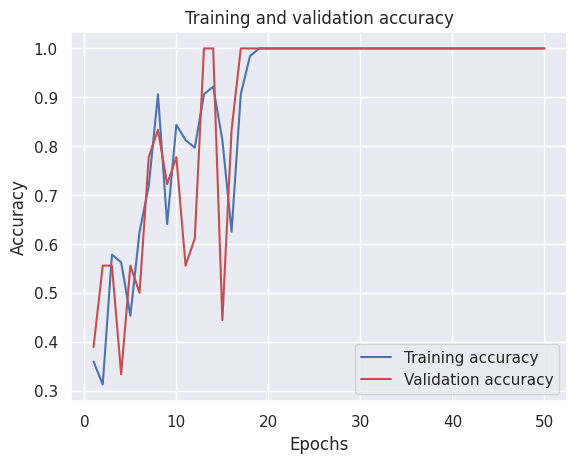

In [73]:
# Extract the training and validation accuracy from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Create a plot of the training and validation accuracy over time
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

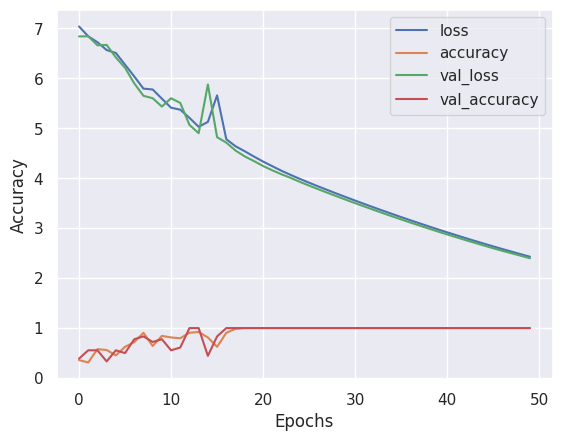

In [74]:
# Get all the available metrics in the history object
metrics = history.history.keys()

# Create a plot for each metric
for metric in metrics:
    plt.plot(history.history[metric], label=metric)

# Add a legend and axis labels
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Show the plot
plt.show()

# 9. Evaluation using Confusion Matrix and Accuracy

In [75]:
yhat = hypermodel.predict(X_test)

1/1 [==============================] - 1s 686ms/step


In [76]:
ytrue = np.argmax(y_test, axis=1).tolist()
ytrue

[1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0]

In [77]:
yhat = np.argmax(yhat, axis=1).tolist()
yhat

[1, 0, 1, 2, 2, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 2, 0, 2]

In [78]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[10,  0],
        [ 4,  4]],

       [[12,  0],
        [ 0,  6]],

       [[10,  4],
        [ 0,  4]]])

In [79]:
accuracy_score(ytrue, yhat)

0.7777777777777778

In [80]:
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

1/1 [==============================] - 0s 65ms/step - loss: 5.2586 - accuracy: 0.7778
[test loss, test accuracy]: [5.25861930847168, 0.7777777910232544]


# 10. Make Predictions

In [81]:
hypermodel.predict(X_test)

1/1 [==============================] - 0s 62ms/step


array([[2.6445460e-04, 9.9624538e-01, 3.4901232e-03],
       [7.0921189e-01, 3.1622457e-03, 2.8762588e-01],
       [2.9071042e-04, 9.9501890e-01, 4.6904623e-03],
       [1.0453435e-01, 2.1276122e-02, 8.7418950e-01],
       [3.8964453e-01, 1.8386893e-03, 6.0851675e-01],
       [2.0189191e-01, 4.7301273e-03, 7.9337811e-01],
       [2.4226062e-04, 9.9653673e-01, 3.2210241e-03],
       [8.7518394e-02, 7.2308453e-03, 9.0525061e-01],
       [6.6966045e-01, 3.3548977e-03, 3.2698452e-01],
       [2.4549736e-04, 9.9594080e-01, 3.8136428e-03],
       [5.5691257e-02, 1.1512500e-02, 9.3279630e-01],
       [2.8444122e-04, 9.9516118e-01, 4.5543206e-03],
       [2.4684696e-04, 9.9609536e-01, 3.6576930e-03],
       [1.6271329e-01, 1.6564934e-02, 8.2072175e-01],
       [6.7103654e-01, 3.4073626e-03, 3.2555601e-01],
       [2.4736689e-01, 3.3606887e-03, 7.4927241e-01],
       [6.7393696e-01, 3.6119493e-03, 3.2245106e-01],
       [2.1486640e-01, 4.0589091e-03, 7.8107470e-01]], dtype=float32)

In [82]:
res = hypermodel.predict(X_test)

1/1 [==============================] - 0s 54ms/step


In [83]:
# let's check if the model is making correct predictions
for i in range(5):
    print('\nPredicted Action:',actions[np.argmax(res[i])])
    print('Actual Action:',actions[np.argmax(y_test[i])])


Predicted Action: thanks
Actual Action: thanks

Predicted Action: hello
Actual Action: hello

Predicted Action: thanks
Actual Action: thanks

Predicted Action: ok
Actual Action: ok

Predicted Action: ok
Actual Action: hello


# 11. Save Weights

After saving weights, even if you delete the model, you can use the weights to leverage later. 
Just run the code with model structure and compile that then w/o training, you can load weights.

In [84]:
hypermodel.save('action.h5')

In [62]:
# del hypermodel

In [26]:
hypermodel.load_weights('action.h5')

NameError: name 'hypermodel' is not defined

# 12. Test in Real Time

In [85]:
colors = [(245,117,16), (117,245,16), (16,117,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
#     print(res)
#     res= [[8.7557790e-05 9.9966586e-01 2.4660953e-04]
#           [5.1199573e-01 1.1992838e-02 4.7601143e-01]
#           [1.0263464e-02 9.6325117e-01 2.6485272e-02]]
    for i, action_probs in enumerate(res):
        cv2.rectangle(output_frame, (0,60+i*40), (int(action_probs*100), 90+i*40), colors[i], -1)
        cv2.putText(output_frame, actions[i], (0, 85+i*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    return output_frame

In [93]:
# 1. detection variables:
# sequence will hold the 30 frames in order to be able to generate a prediction
# as we're looping through the frame using opencv, we're gonna append to sequence, 
# and once we have 30 frames, then we'll pass it to our prediction algorithms 
sequence = [] 
# sentence is going to allow us to concatenate our history of detections together
sentence = []
# threshold is sorta like our confidence metric; we're only gonna render results only if they're above this threshold
threshold = 0.4
predictions=[]

cap = cv2.VideoCapture(2)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:] # grab the end 30 sequences
        
        if len(sequence) == 30:
            res = hypermodel.predict(np.expand_dims(sequence, axis=0))[0] # next cell for expand_dims
            print(actions[np.argmax(res)])   
            predictions.append(np.argmax(res))
            
        #3. Viz logic
        if len(predictions) > 0 and np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

        if len(sentence) > 5: 
            sentence = sentence[-5:]
            
        # Viz probabilities
        image = prob_viz(res, actions, image, colors)
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()
    
# if the code shows some error :
# step1: comment out following two lines and then run
#         image = prob_viz(res, actions, image, colors)
#         cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
# if there's an error again, replace actions[np.argmax(res)] with ' '.join(sentence) and run
# then if error, uncomment and run again; try combinations.

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

1/1 [==============================] - 0s 32ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 36ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 31ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 33ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOutputs'>
1/1 [==============================] - 0s 32ms/step
ok
<class 'mediapipe.python.solution_base.SolutionOu

In [89]:
# cap.release()
# cv2.destroyAllWindows()

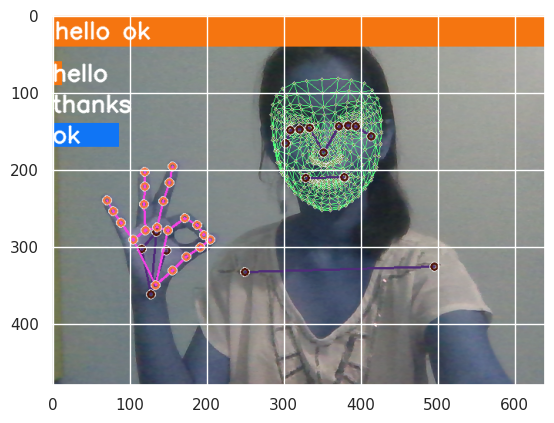

In [94]:
plt.imshow(prob_viz(res, actions, image, colors))
# can remove the grid and axes with : plt.axis('off') 

### END OF CODE

In [ ]:
# better understanding of expand_dims:
hypermodel.predict(X_test)

In [ ]:
X_test.shape

In [ ]:
# but when predicting it gives an error for its shape is incompatible
hypermodel.predict(X_test[0])

In [ ]:
X_test[0].shape

In [ ]:
# but the shape that our sequence is expecting is (1,30,1662) ie (num_sequences,30,1662)
np.expand_dims(X_test[0],axis=0).shape